In [23]:
# Import libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Set view options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [25]:
# Read in slurm time series, ce5/ce6 time series, and ce5/ce6 log
slurm_time_series = pd.read_csv('../data/slurm_time_series.csv', index_col = 'TIMESTAMP', parse_dates = True)
ce5_ce6_time_series = pd.read_csv('../data/ce5_ce6_time_series.csv', index_col = 'TIMESTAMP', parse_dates = True)
ce5_ce6_log = pd.read_csv('../data/slurm_wrapper_ce5_ce6.csv', index_col = 'TIMESTAMP', parse_dates = True)

In [26]:
# Perform rolling windows on slurm time series data
agg_dict = {'STARTEDJOBS': 'sum',
            'RUNNINGJOBS': 'mean',
            'ENDEDJOBS': 'sum',
            'REQMEMTOT': 'mean',
            'USEDMEM': 'mean',
            'NODES': 'mean',
            'CPUS': 'mean',
}

mask = slurm_time_series.index.to_series().between('2021-05-18', '2021-06-01')

slurm_1hour_rolling = slurm_time_series.rolling('1H').agg(agg_dict)
slurm_1hour_rolling = slurm_1hour_rolling[~mask]

In [27]:
# Filter intervals with at least 1 user 9204 sbatch command
user_9204_sbatch = ce5_ce6_time_series[ce5_ce6_time_series['USER_9204_SBATCH_COMMANDS'] > 0]

# Create TIMEOUT column
user_9204_sbatch = user_9204_sbatch.assign(TIMEOUT = (user_9204_sbatch['USER_9204_SBATCH_TIMEOUTS'] > 0).astype(int))

# Merge slurm and ce5/ce6 time series
user_9204_sbatch_slurm_jobs = pd.merge(slurm_1hour_rolling, user_9204_sbatch, left_index = True, right_index = True)

In [28]:
# Build logistic model for user 9204 sbatch timeouts vs. ended jobs
user_9204_sbatch_ended_jobs_model = glm(formula = 'TIMEOUT ~ ENDEDJOBS', 
                                        data = user_9204_sbatch_slurm_jobs,
                                        family = sm.families.Binomial()
                                       ).fit()

# Display model summary
display(user_9204_sbatch_ended_jobs_model.summary())
print(f'Model AIC: {user_9204_sbatch_ended_jobs_model.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                TIMEOUT   No. Observations:                50329
Model:                            GLM   Df Residuals:                    50327
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10189.
Date:                Mon, 15 Nov 2021   Deviance:                       20378.
Time:                        23:50:19   Pearson chi2:                 5.03e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8794      0.025   -114.026      0.000      -2.929      -2.830
ENDEDJOBS  -4.636e-05   1.97e-05     -2.348      0.019   -8.51e-05   -7.66e-06
==============================================================================
"""

Model AIC: 20381.938059583455


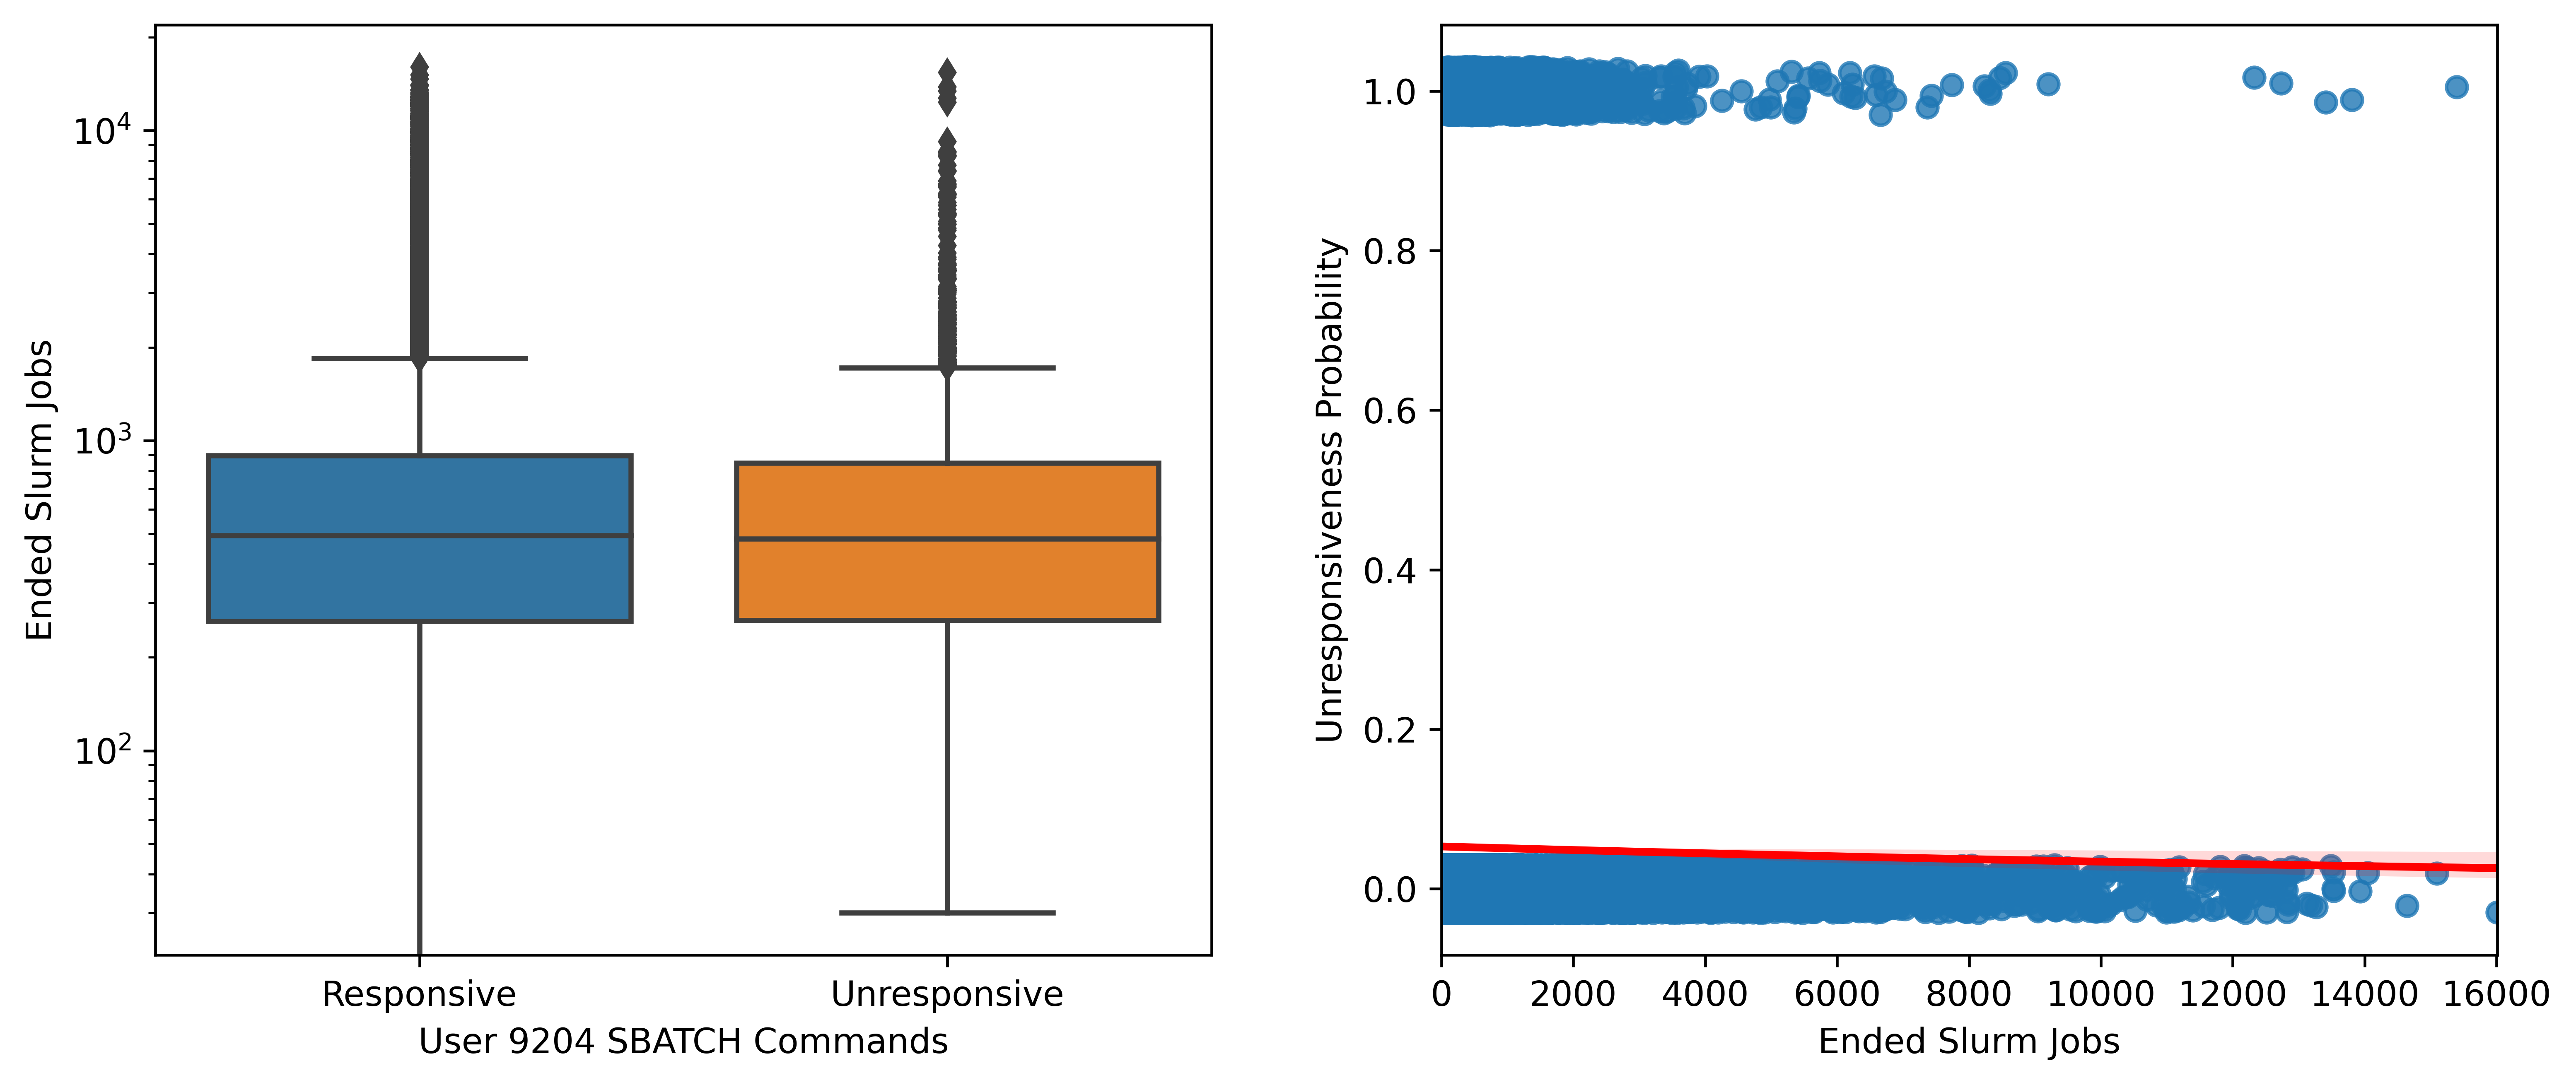

In [29]:
# Plot boxplot and logistic model fit for user 9204 sbatch timeouts vs. ended jobs
fig, axs = plt.subplots(1, 2, figsize = (11, 5), facecolor = 'white', dpi = 600)

sns.boxplot(x = 'TIMEOUT', 
            y = 'ENDEDJOBS', 
            data = user_9204_sbatch_slurm_jobs,
            ax = axs[0]
)

axs[0].set_xticklabels(['Responsive', 'Unresponsive'])
axs[0].set_xlabel('User 9204 SBATCH Commands')
axs[0].set_ylabel('Ended Slurm Jobs')
axs[0].set_yscale('log')

sns.regplot(x = 'ENDEDJOBS', 
            y = 'TIMEOUT', 
            data = user_9204_sbatch_slurm_jobs, 
            logistic = True, 
            line_kws = {'color': 'red'}, 
            y_jitter = 0.03, 
            ax = axs[1]
)

axs[1].set_xlabel('Ended Slurm Jobs')
axs[1].set_ylabel('Unresponsiveness Probability')

fig.tight_layout(pad = 3)

plt.show()

In [30]:
# Build logistic model for user 9204 sbatch timeouts vs. running jobs
user_9204_sbatch_running_jobs_model = glm(formula = 'TIMEOUT ~ RUNNINGJOBS', 
                                          data = user_9204_sbatch_slurm_jobs,
                                          family = sm.families.Binomial()
                                         ).fit()

# Display model summary
display(user_9204_sbatch_running_jobs_model.summary())
print(f'Model AIC: {user_9204_sbatch_running_jobs_model.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                TIMEOUT   No. Observations:                50329
Model:                            GLM   Df Residuals:                    50327
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9792.3
Date:                Mon, 15 Nov 2021   Deviance:                       19585.
Time:                        23:50:50   Pearson chi2:                 4.91e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.1690      0.091    -56.619      0.000      -5.348      -4.990
RUNNINGJOBS     0.0006   2.38e-05     26.942      0.000       0.001       0.001
===============================================================================
"""

Model AIC: 19588.601895594733


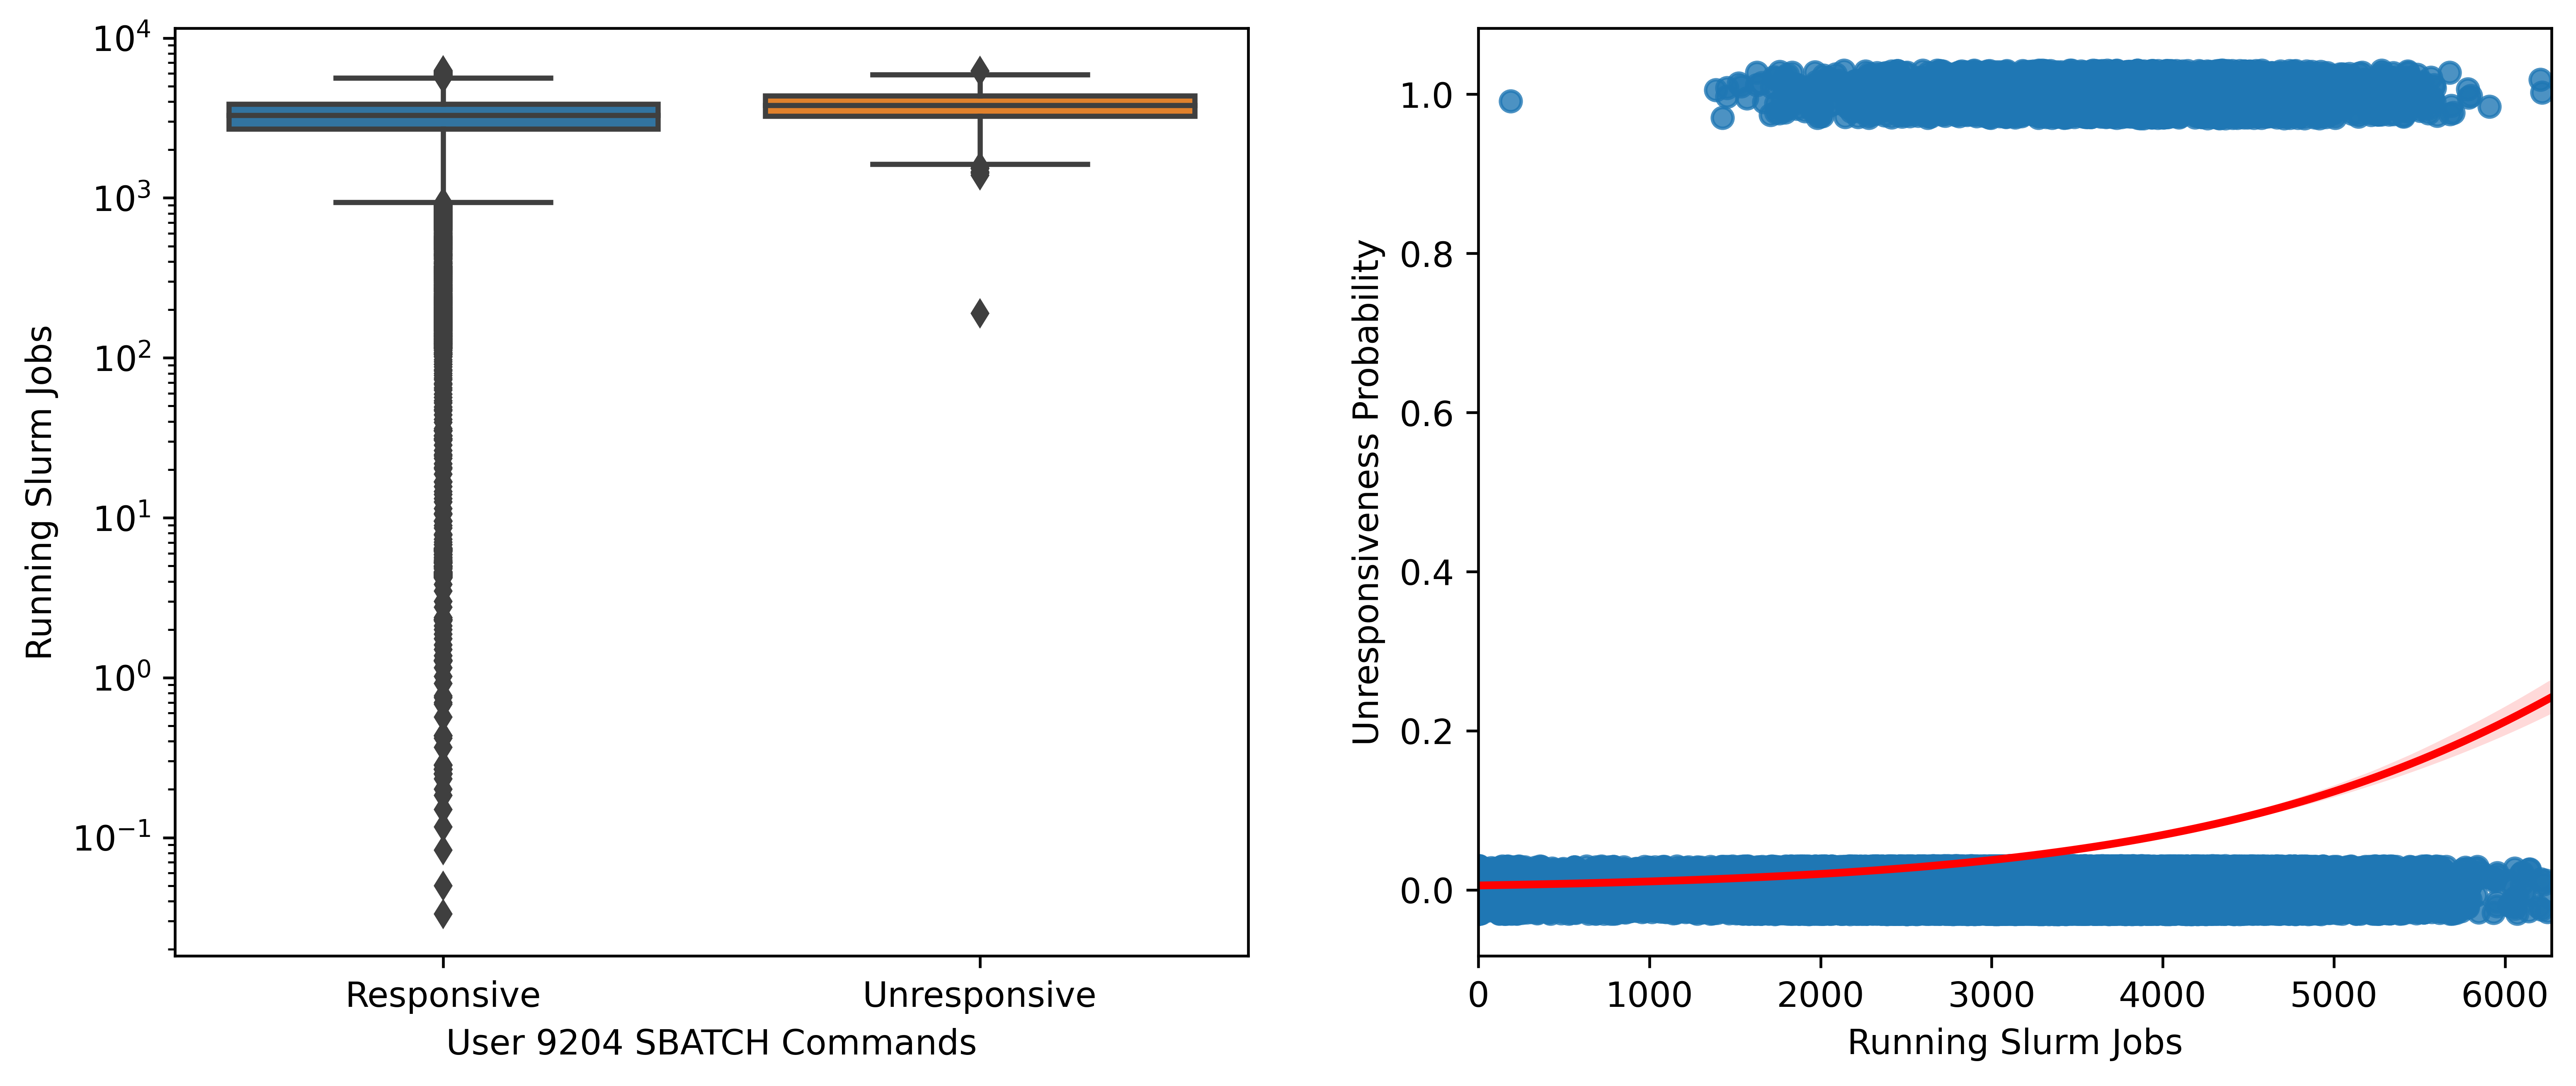

In [31]:
# Plot boxplot and logistic model fit for user 9204 sbatch timeouts vs. running jobs
fig, axs = plt.subplots(1, 2, figsize = (11, 5), facecolor = 'white', dpi = 600)

sns.boxplot(x = 'TIMEOUT', 
            y = 'RUNNINGJOBS', 
            data = user_9204_sbatch_slurm_jobs,
            ax = axs[0]
)

axs[0].set_xticklabels(['Responsive', 'Unresponsive'])
axs[0].set_xlabel('User 9204 SBATCH Commands')
axs[0].set_ylabel('Running Slurm Jobs')
axs[0].set_yscale('log')

sns.regplot(x = 'RUNNINGJOBS', 
            y = 'TIMEOUT', 
            data = user_9204_sbatch_slurm_jobs, 
            logistic = True, 
            line_kws = {'color': 'red'}, 
            y_jitter = 0.03, 
            ax = axs[1]
)

axs[1].set_xlabel('Running Slurm Jobs')
axs[1].set_ylabel('Unresponsiveness Probability')

fig.tight_layout(pad = 3)

plt.show()

In [32]:
# Filter intervals with at least 1 command
all_commands = ce5_ce6_time_series[ce5_ce6_time_series['COMMANDS'] > 0]

# Create TIMEOUT column
all_commands = all_commands.assign(TIMEOUT = (all_commands['TIMEOUTS'] > 0).astype(int))

# Merge slurm and ce5/ce6 time series
all_commands_slurm_jobs = pd.merge(slurm_1hour_rolling, all_commands, left_index = True, right_index = True)

In [33]:
# Build logistic model for all timeouts vs. ended jobs
all_commands_ended_jobs_model = glm(formula = 'TIMEOUT ~ ENDEDJOBS', 
                                    data = all_commands_slurm_jobs,
                                    family = sm.families.Binomial()
                                   ).fit()

# Display model summary
display(all_commands_ended_jobs_model.summary())
print(f'Model AIC: {all_commands_ended_jobs_model.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                TIMEOUT   No. Observations:               483434
Model:                            GLM   Df Residuals:                   483432
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3546e+05
Date:                Mon, 15 Nov 2021   Deviance:                   2.7092e+05
Time:                        23:51:25   Pearson chi2:                 4.83e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4230      0.006   -373.672      0.000      -2.436      -2.410
ENDEDJOBS  -1.348e-05   4.52e-06     -2.982      0.003   -2.23e-05   -4.62e-06
==============================================================================
"""

Model AIC: 270924.190850332


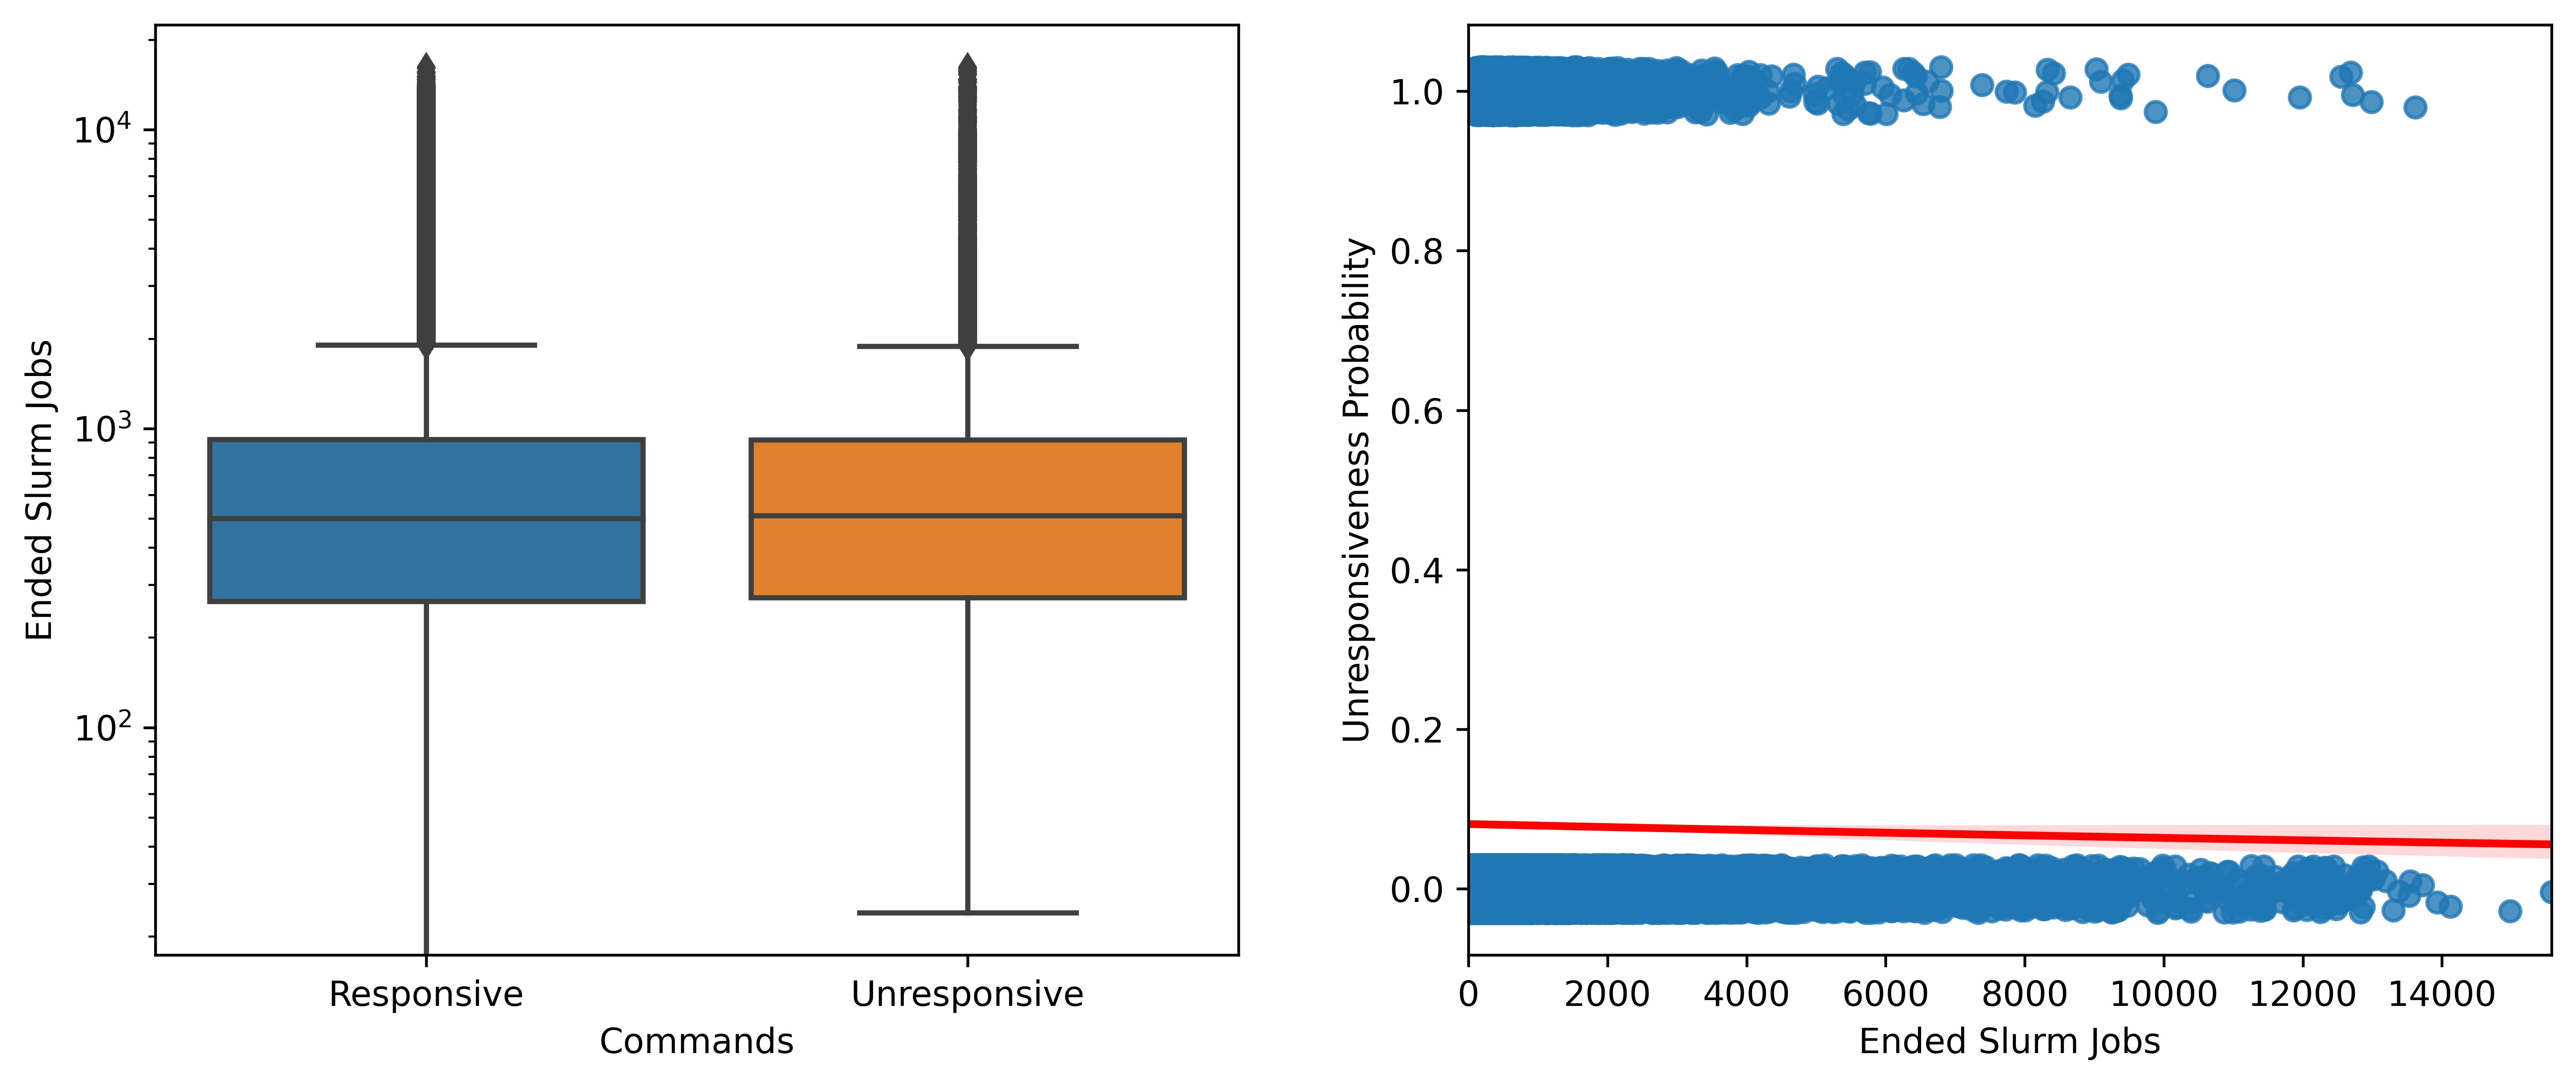

In [34]:
# Plot boxplot and logistic model fit for all timeouts vs. ended jobs
fig, axs = plt.subplots(1, 2, figsize = (11, 5), facecolor = 'white', dpi = 600)

sns.boxplot(x = 'TIMEOUT', 
            y = 'ENDEDJOBS', 
            data = all_commands_slurm_jobs,
            ax = axs[0]
)

axs[0].set_xticklabels(['Responsive', 'Unresponsive'])
axs[0].set_xlabel('Commands')
axs[0].set_ylabel('Ended Slurm Jobs')
axs[0].set_yscale('log')

sns.regplot(x = 'ENDEDJOBS', 
            y = 'TIMEOUT', 
            data = all_commands_slurm_jobs.sample(50000), 
            logistic = True, 
            line_kws = {'color': 'red'}, 
            y_jitter = 0.03, 
            ax = axs[1]
)

axs[1].set_xlabel('Ended Slurm Jobs')
axs[1].set_ylabel('Unresponsiveness Probability')

fig.tight_layout(pad = 3)

plt.show()

In [35]:
# Build logistic model for all timeouts vs. running jobs
all_commands_running_jobs_model = glm(formula = 'TIMEOUT ~ RUNNINGJOBS', 
                                      data = all_commands_slurm_jobs,
                                      family = sm.families.Binomial()
                                     ).fit()

# Display model summary
display(all_commands_running_jobs_model.summary())
print(f'Model AIC: {all_commands_running_jobs_model.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                TIMEOUT   No. Observations:               483434
Model:                            GLM   Df Residuals:                   483432
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3028e+05
Date:                Mon, 15 Nov 2021   Deviance:                   2.6055e+05
Time:                        23:51:53   Pearson chi2:                 4.72e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.5297      0.023   -194.026      0.000      -4.575      -4.484
RUNNINGJOBS     0.0006    6.2e-06     97.474      0.000       0.001       0.001
===============================================================================
"""

Model AIC: 260554.9529724048


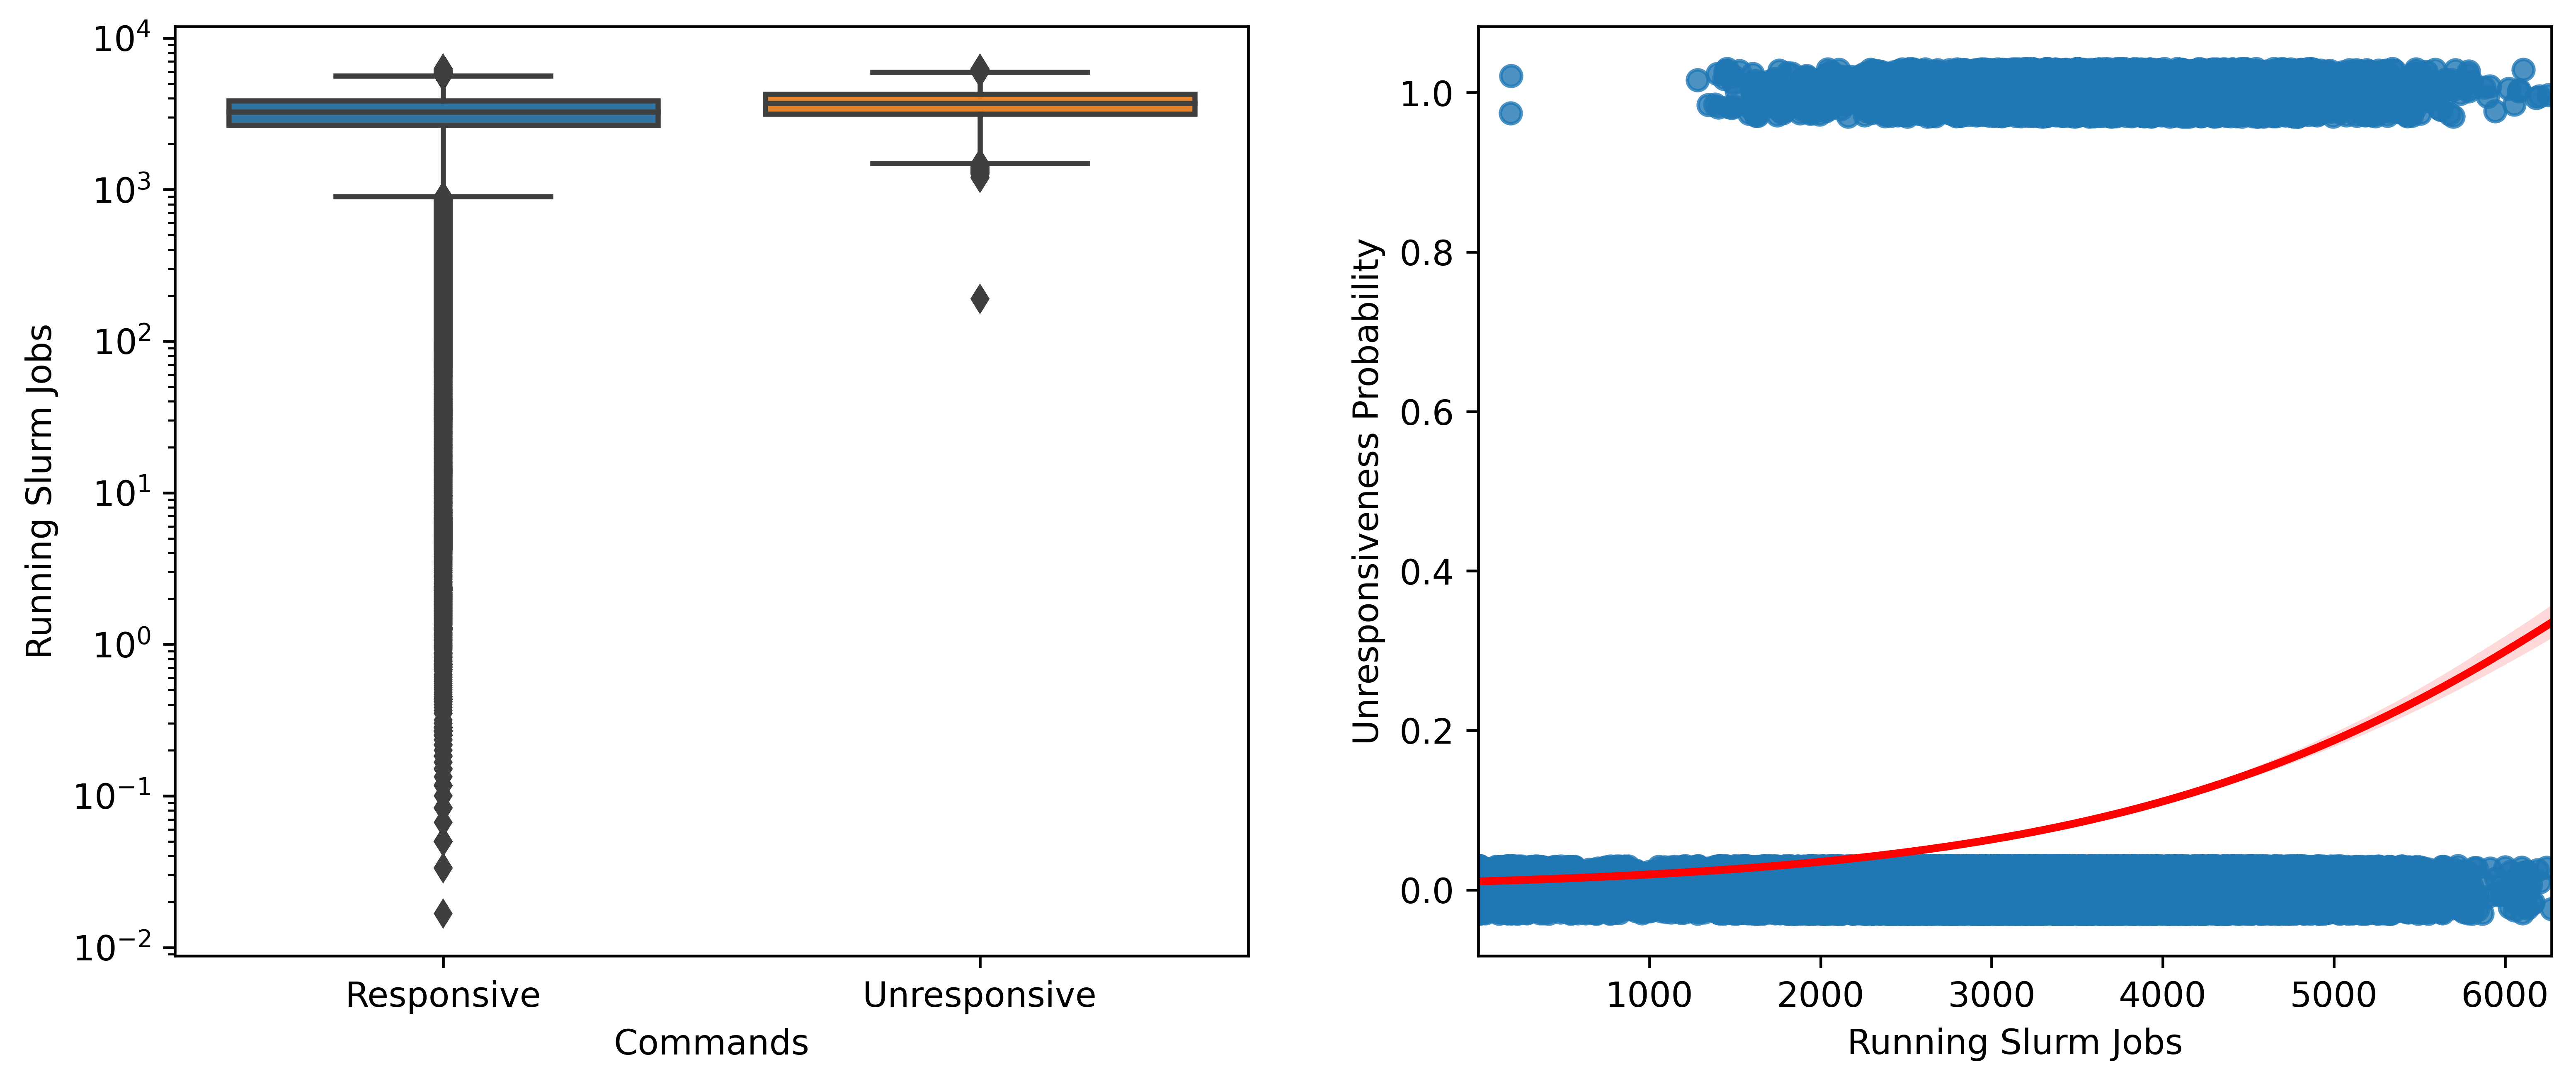

In [36]:
# Plot boxplot and logistic model fit for all timeouts vs. running jobs
fig, axs = plt.subplots(1, 2, figsize = (11, 5), facecolor = 'white', dpi = 600)

sns.boxplot(x = 'TIMEOUT', 
            y = 'RUNNINGJOBS',
            data = all_commands_slurm_jobs,
            ax = axs[0]
)

axs[0].set_xticklabels(['Responsive', 'Unresponsive'])
axs[0].set_xlabel('Commands')
axs[0].set_ylabel('Running Slurm Jobs')
axs[0].set_yscale('log')

sns.regplot(x = 'RUNNINGJOBS', 
            y = 'TIMEOUT', 
            data = all_commands_slurm_jobs.sample(50000), 
            logistic = True, 
            line_kws = {'color': 'red'}, 
            y_jitter = 0.03, 
            ax = axs[1]
)

axs[1].set_xlabel('Running Slurm Jobs')
axs[1].set_ylabel('Unresponsiveness Probability')

fig.tight_layout(pad = 3)

plt.show()

In [37]:
# Calculate timeout percentage
timeout_pct = 100 * ce5_ce6_time_series['TIMEOUTS'].sum() / ce5_ce6_time_series['COMMANDS'].sum()
print(f'Timeout Percentage: {timeout_pct:.2f}%')

# Calculate sbatch timeout percentage
sbatch_timeout_pct = 100 * ce5_ce6_time_series['SBATCH_TIMEOUTS'].sum() / ce5_ce6_time_series['SBATCH_COMMANDS'].sum()
print(f'SBATCH Timeout Percentage: {sbatch_timeout_pct:.2f}%')

# Calculate user 9204 sbatch timeout percentage
user_9204_sbatch_timeout_pct = 100 * ce5_ce6_time_series['USER_9204_SBATCH_TIMEOUTS'].sum() / ce5_ce6_time_series['USER_9204_SBATCH_COMMANDS'].sum()
print(f'User 9204 SBATCH Timeout Percentage: {user_9204_sbatch_timeout_pct:.2f}%')

Timeout Percentage: 10.89%
SBATCH Timeout Percentage: 6.70%
User 9204 SBATCH Timeout Percentage: 5.38%


In [38]:
# Perform 1 hour resample of ce5/ce6 time series data
ce5_ce6_1_hour_resample = ce5_ce6_time_series.resample('1H').sum()

# Filter intervals with at least 1 command
ce5_ce6_1_hour_resample = ce5_ce6_1_hour_resample[ce5_ce6_1_hour_resample['COMMANDS'] > 0]

# Create TIMEOUT and TIMEOUT_PCT columns
ce5_ce6_1_hour_resample['TIMEOUT'] = (ce5_ce6_1_hour_resample['TIMEOUTS'] > 0).astype(int)
ce5_ce6_1_hour_resample['TIMEOUT_PCT'] = ce5_ce6_1_hour_resample['TIMEOUTS'] / ce5_ce6_1_hour_resample['COMMANDS']

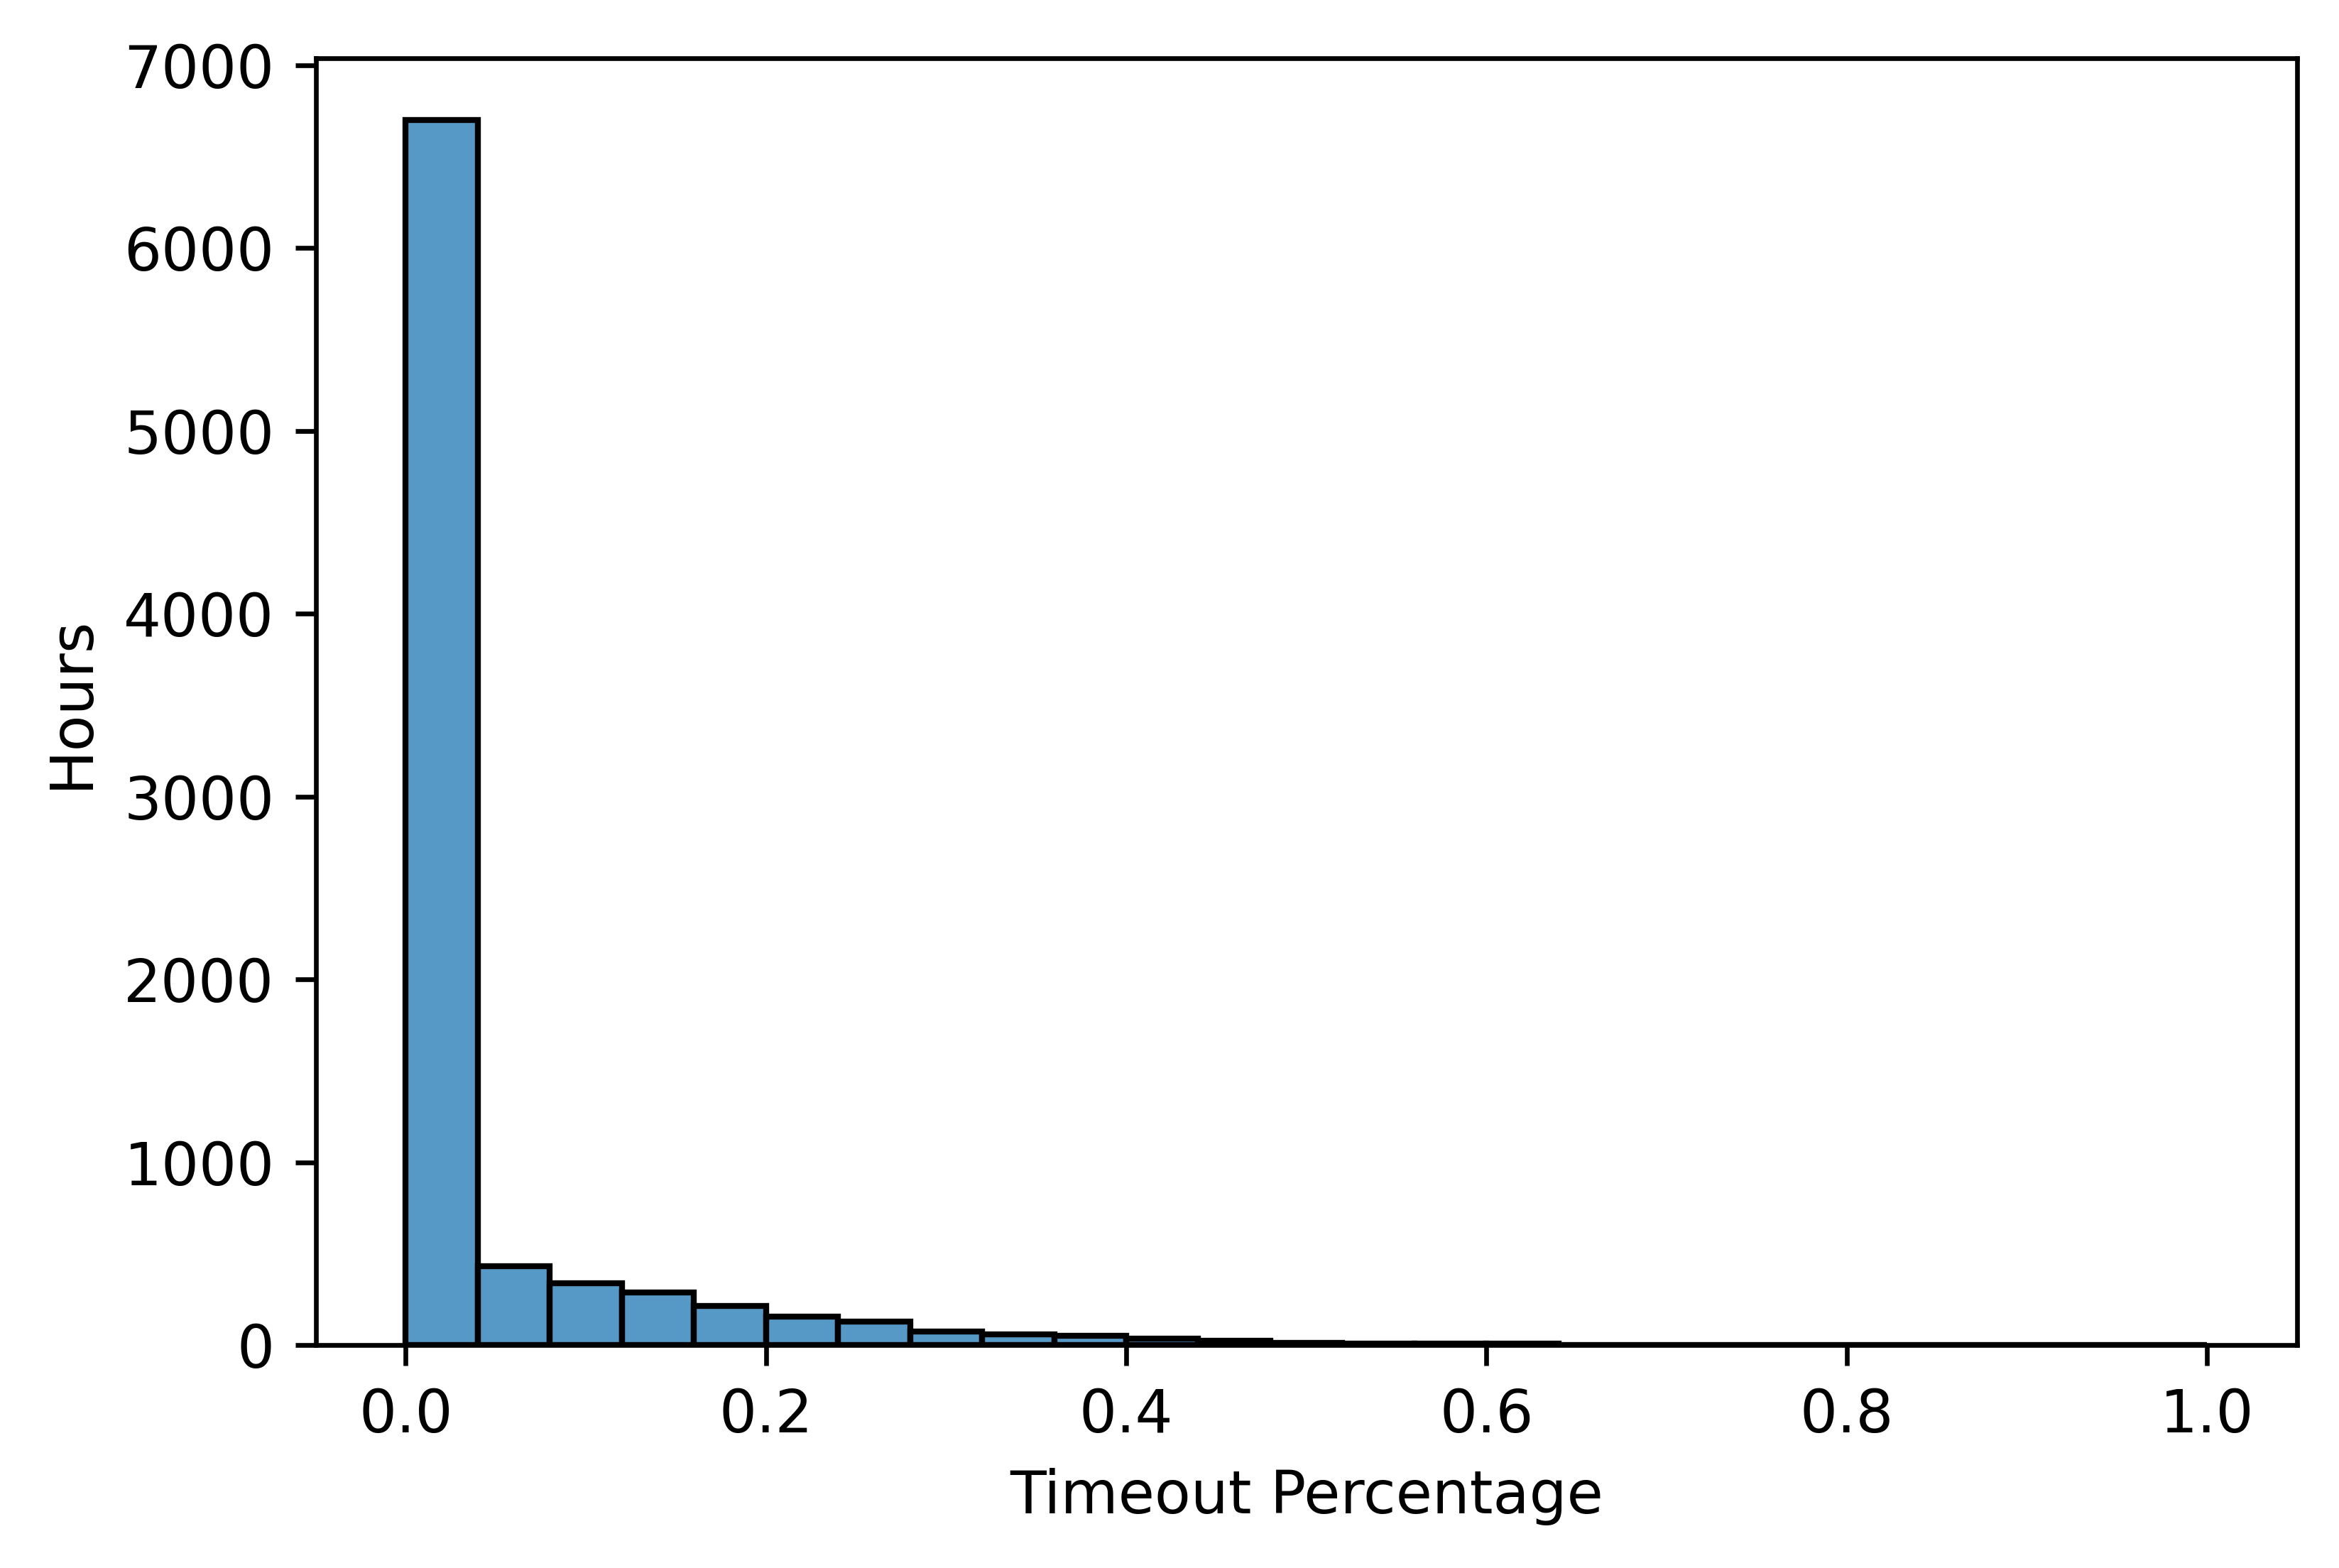

In [39]:
# Plot histogram of timeout percentages by hour
fig, ax = plt.subplots(figsize = (6, 4), facecolor = 'white', dpi = 600)

sns.histplot(data = ce5_ce6_1_hour_resample, x = 'TIMEOUT_PCT', bins = 25, ax = ax)

ax.set_xlabel('Timeout Percentage')
ax.set_ylabel('Hours')

plt.show()

In [46]:
# Perform 1 day resample of ce5/ce6 time series data
ce5_ce6_1_day_resample = ce5_ce6_time_series.resample('1D').sum()

# Filter intervals with at least 1 command
ce5_ce6_1_day_resample = ce5_ce6_1_day_resample[ce5_ce6_1_day_resample['COMMANDS'] > 0]

# Create TIMEOUT and TIMEOUT_PCT columns
ce5_ce6_1_day_resample['TIMEOUT'] = (ce5_ce6_1_day_resample['TIMEOUTS'] > 0).astype(int)
ce5_ce6_1_day_resample['TIMEOUT_PCT'] = ce5_ce6_1_day_resample['TIMEOUTS'] / ce5_ce6_1_day_resample['COMMANDS']

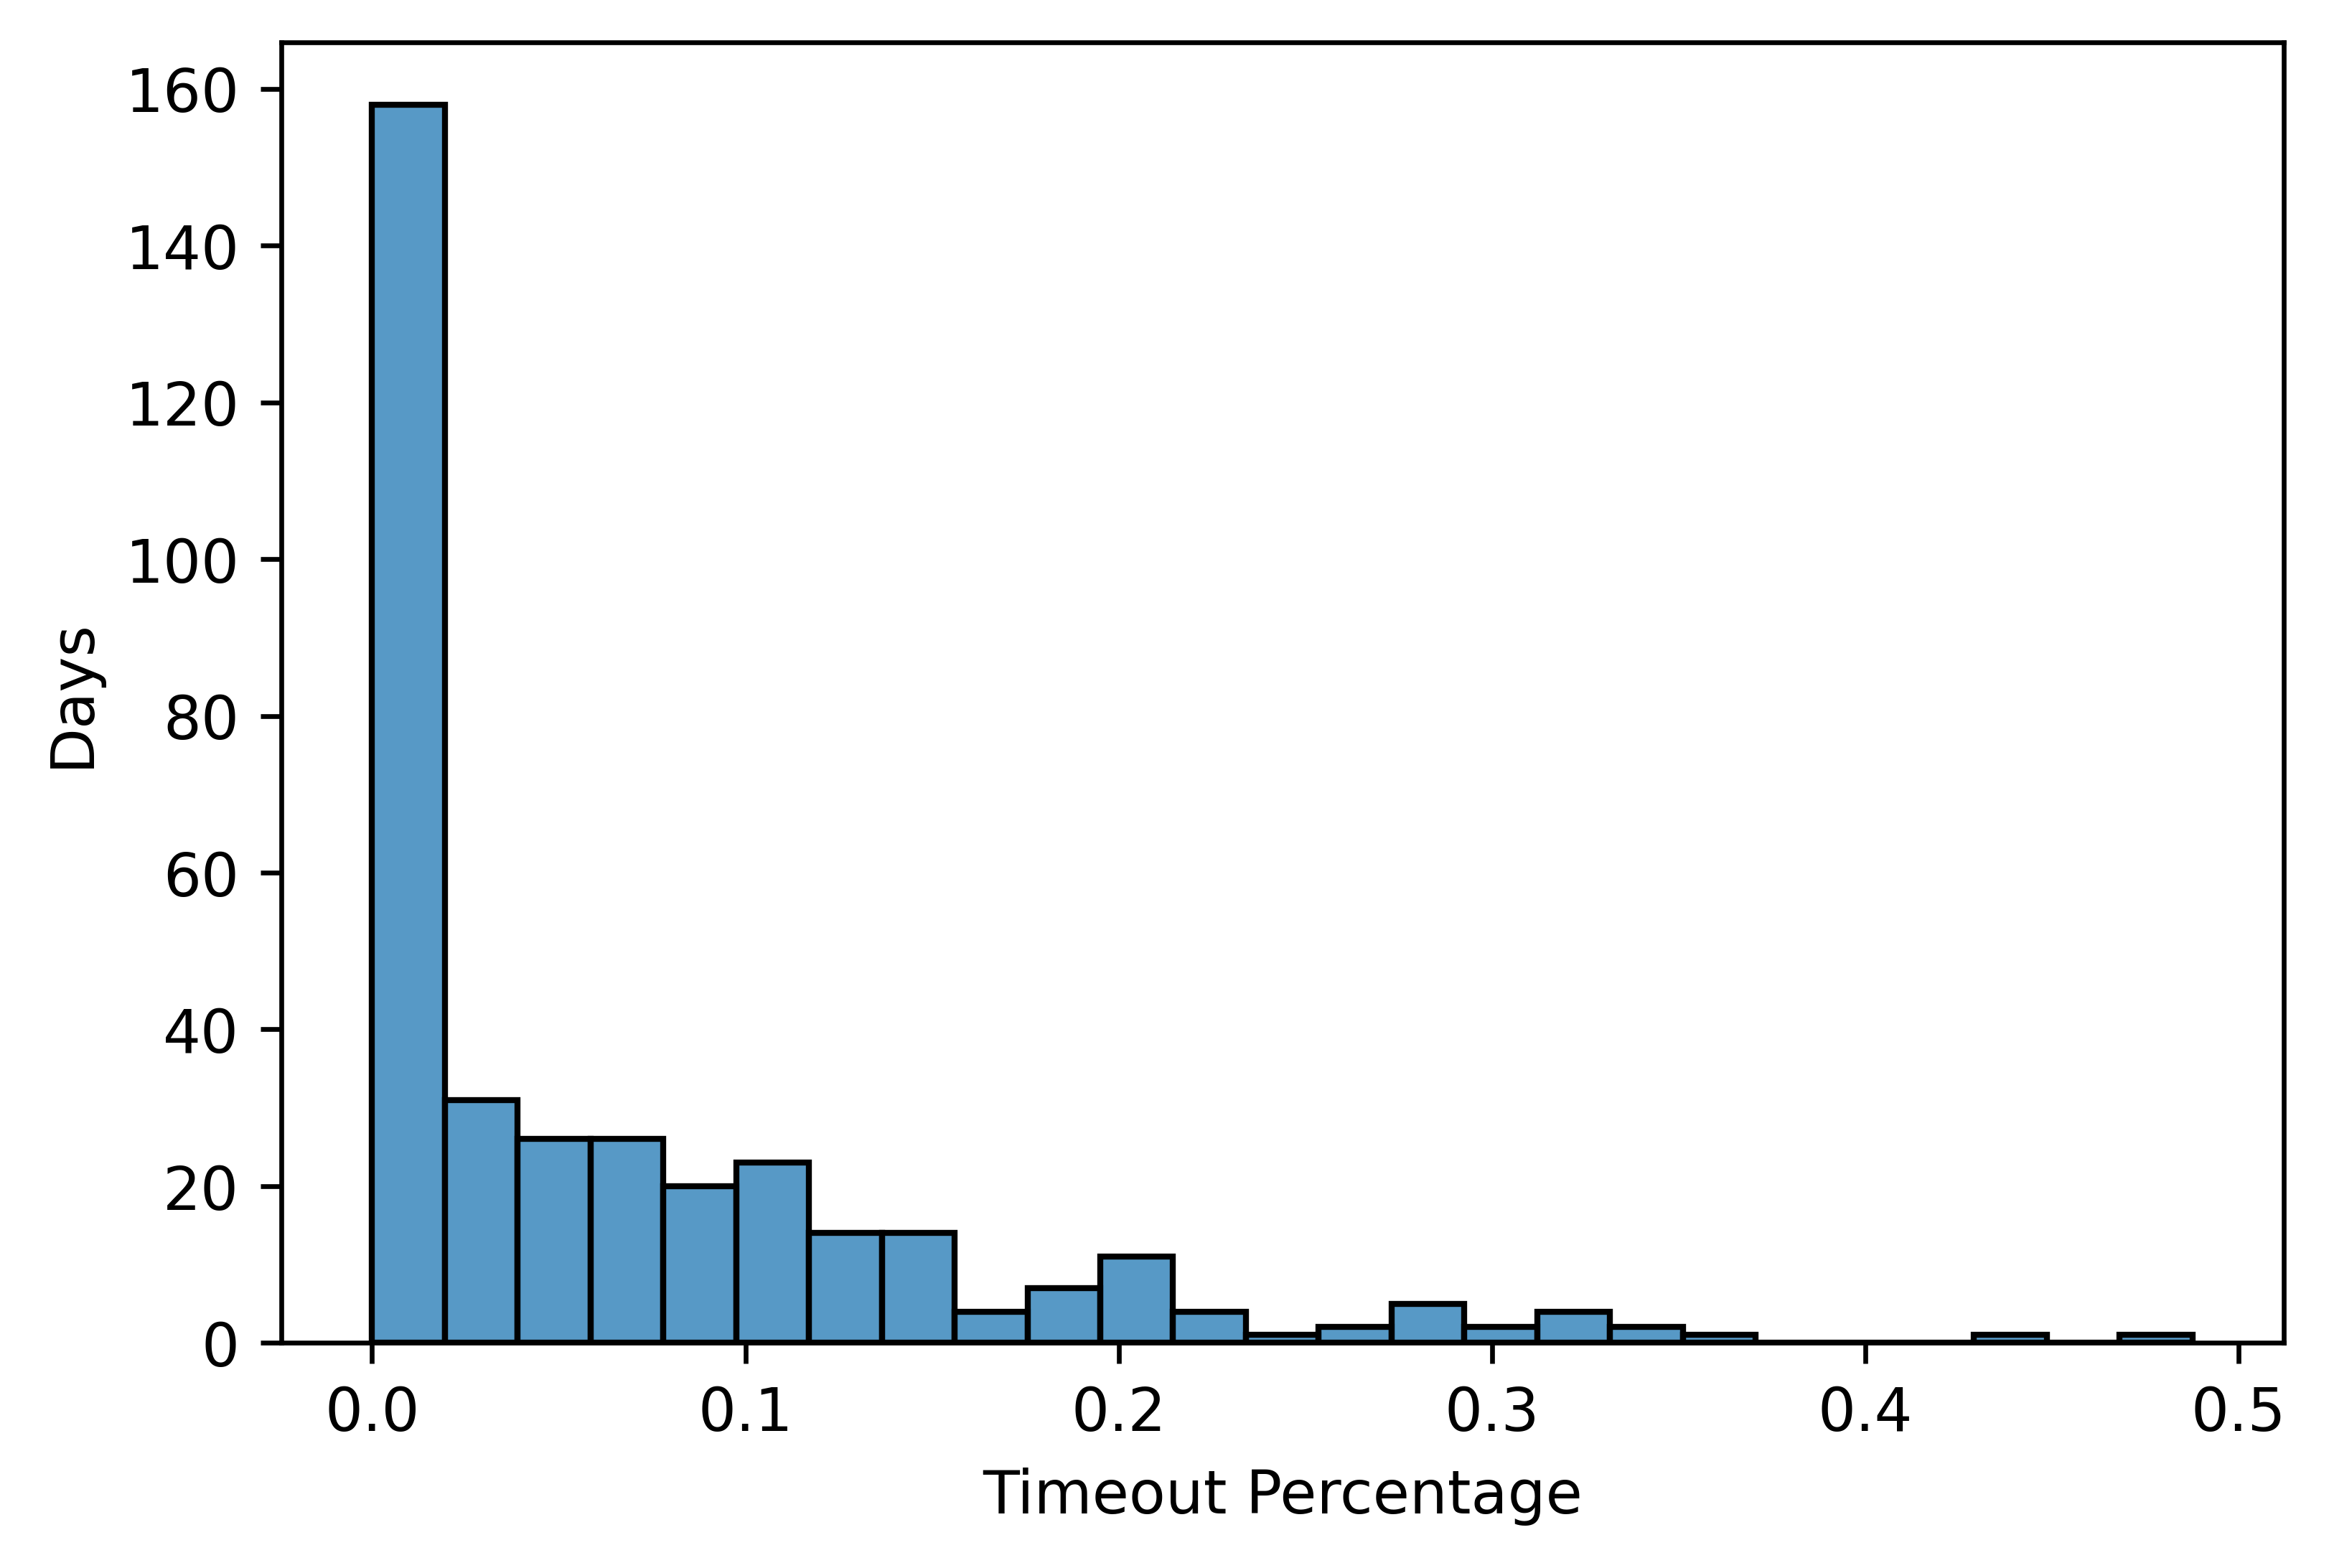

In [47]:
# Plot histogram of timeout percentages by day
fig, ax = plt.subplots(figsize = (6, 4), facecolor = 'white', dpi = 600)

sns.histplot(data = ce5_ce6_1_day_resample, x = 'TIMEOUT_PCT', bins = 25, ax = ax)

ax.set_xlabel('Timeout Percentage')
ax.set_ylabel('Days')

plt.show()

In [40]:
# Build logistic model for timeouts vs. commands (1 hour resample)
timeouts_commands_1_hour_resample_model = glm(formula = 'TIMEOUT ~ COMMANDS', 
                                              data = ce5_ce6_1_hour_resample,
                                              family = sm.families.Binomial()
                                             ).fit()

# Display model summary
display(timeouts_commands_1_hour_resample_model.summary())
print(f'Model AIC: {timeouts_commands_1_hour_resample_model.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                TIMEOUT   No. Observations:                 8558
Model:                            GLM   Df Residuals:                     8556
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4949.8
Date:                Mon, 15 Nov 2021   Deviance:                       9899.7
Time:                        23:52:26   Pearson chi2:                 1.01e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4333      0.039    -37.034      0.000      -1.509      -1.357
COMMANDS       0.0010   3.45e-05     28.599      0.000       0.001       0.001
==============================================================================
"""

Model AIC: 9903.687635905058


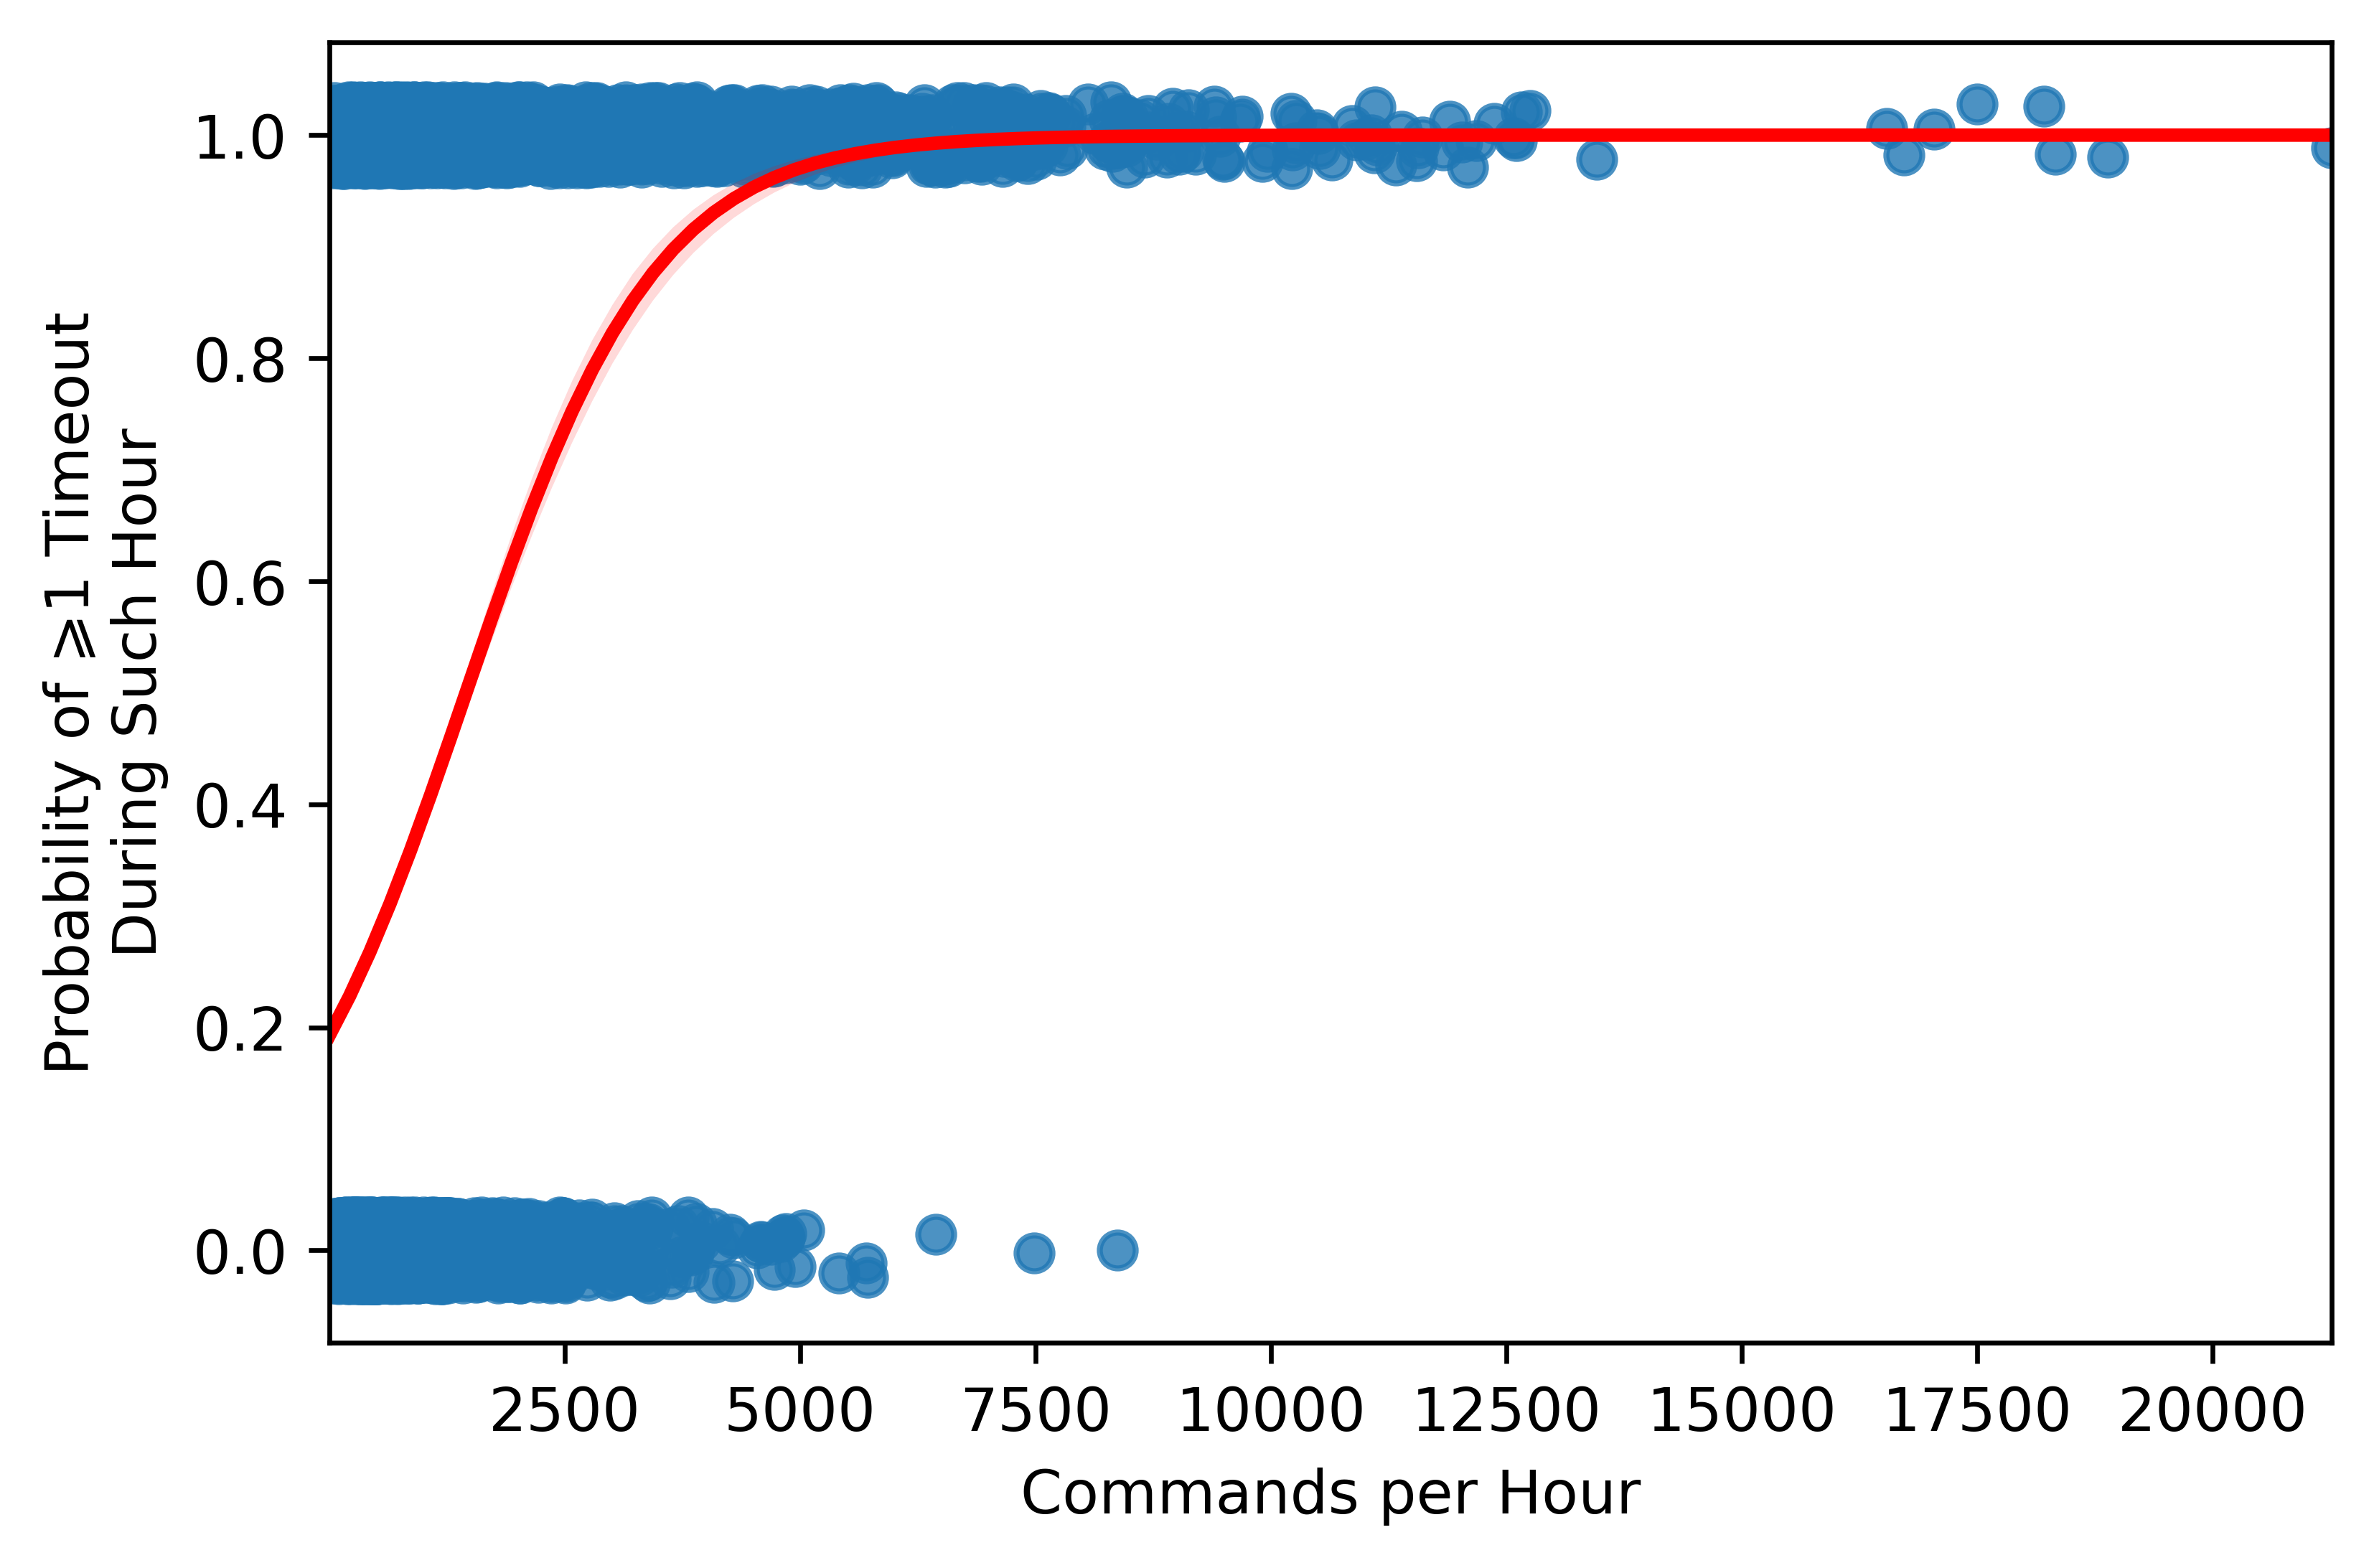

In [45]:
# Plot logistic model fit for timeouts vs. commands (1 hour resample)
fig, ax = plt.subplots(figsize = (6, 4), facecolor = 'white', dpi = 600)

sns.regplot(x = 'COMMANDS', 
            y = 'TIMEOUT', 
            data = ce5_ce6_1_hour_resample,
            logistic = True, 
            line_kws = {"color": "red"}, 
            y_jitter = 0.03, 
            ax = ax
)

ax.set_xlabel('Commands per Hour')
ax.set_ylabel('Probability of ⩾1 Timeout\nDuring Such Hour')

plt.show()

In [42]:
# Perform 1 hour rolling window on ce5/ce6 log COMMANDS column
ce5_ce6_log['COMMANDS'] = ce5_ce6_log.assign(COMMANDS = 1)['COMMANDS'].rolling('1H').sum()

# Create TIMEOUT column
ce5_ce6_log['TIMEOUT'] = ((ce5_ce6_log['RUNTIME'] > 15) & (ce5_ce6_log['RETURNCODE'] > 0)).astype(int)

In [43]:
# Build logistic model for timeouts vs. commands (1 hour rolling)
timeouts_commands_1_hour_rolling_model = glm(formula = 'TIMEOUT ~ COMMANDS', 
                                             data = ce5_ce6_log,
                                             family = sm.families.Binomial()
                                            ).fit()

# Display model summary
display(timeouts_commands_1_hour_rolling_model.summary())
print(f'Model AIC: {timeouts_commands_1_hour_rolling_model.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                TIMEOUT   No. Observations:              9547413
Model:                            GLM   Df Residuals:                  9547411
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.9511e+06
Date:                Mon, 15 Nov 2021   Deviance:                   5.9022e+06
Time:                        23:52:49   Pearson chi2:                 8.81e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9460      0.002  -1770.755      0.000      -2.949      -2.943
COMMANDS       0.0002   2.73e-07    809.208      0.000       0.000       0.000
==============================================================================
"""

Model AIC: 5902188.757575061


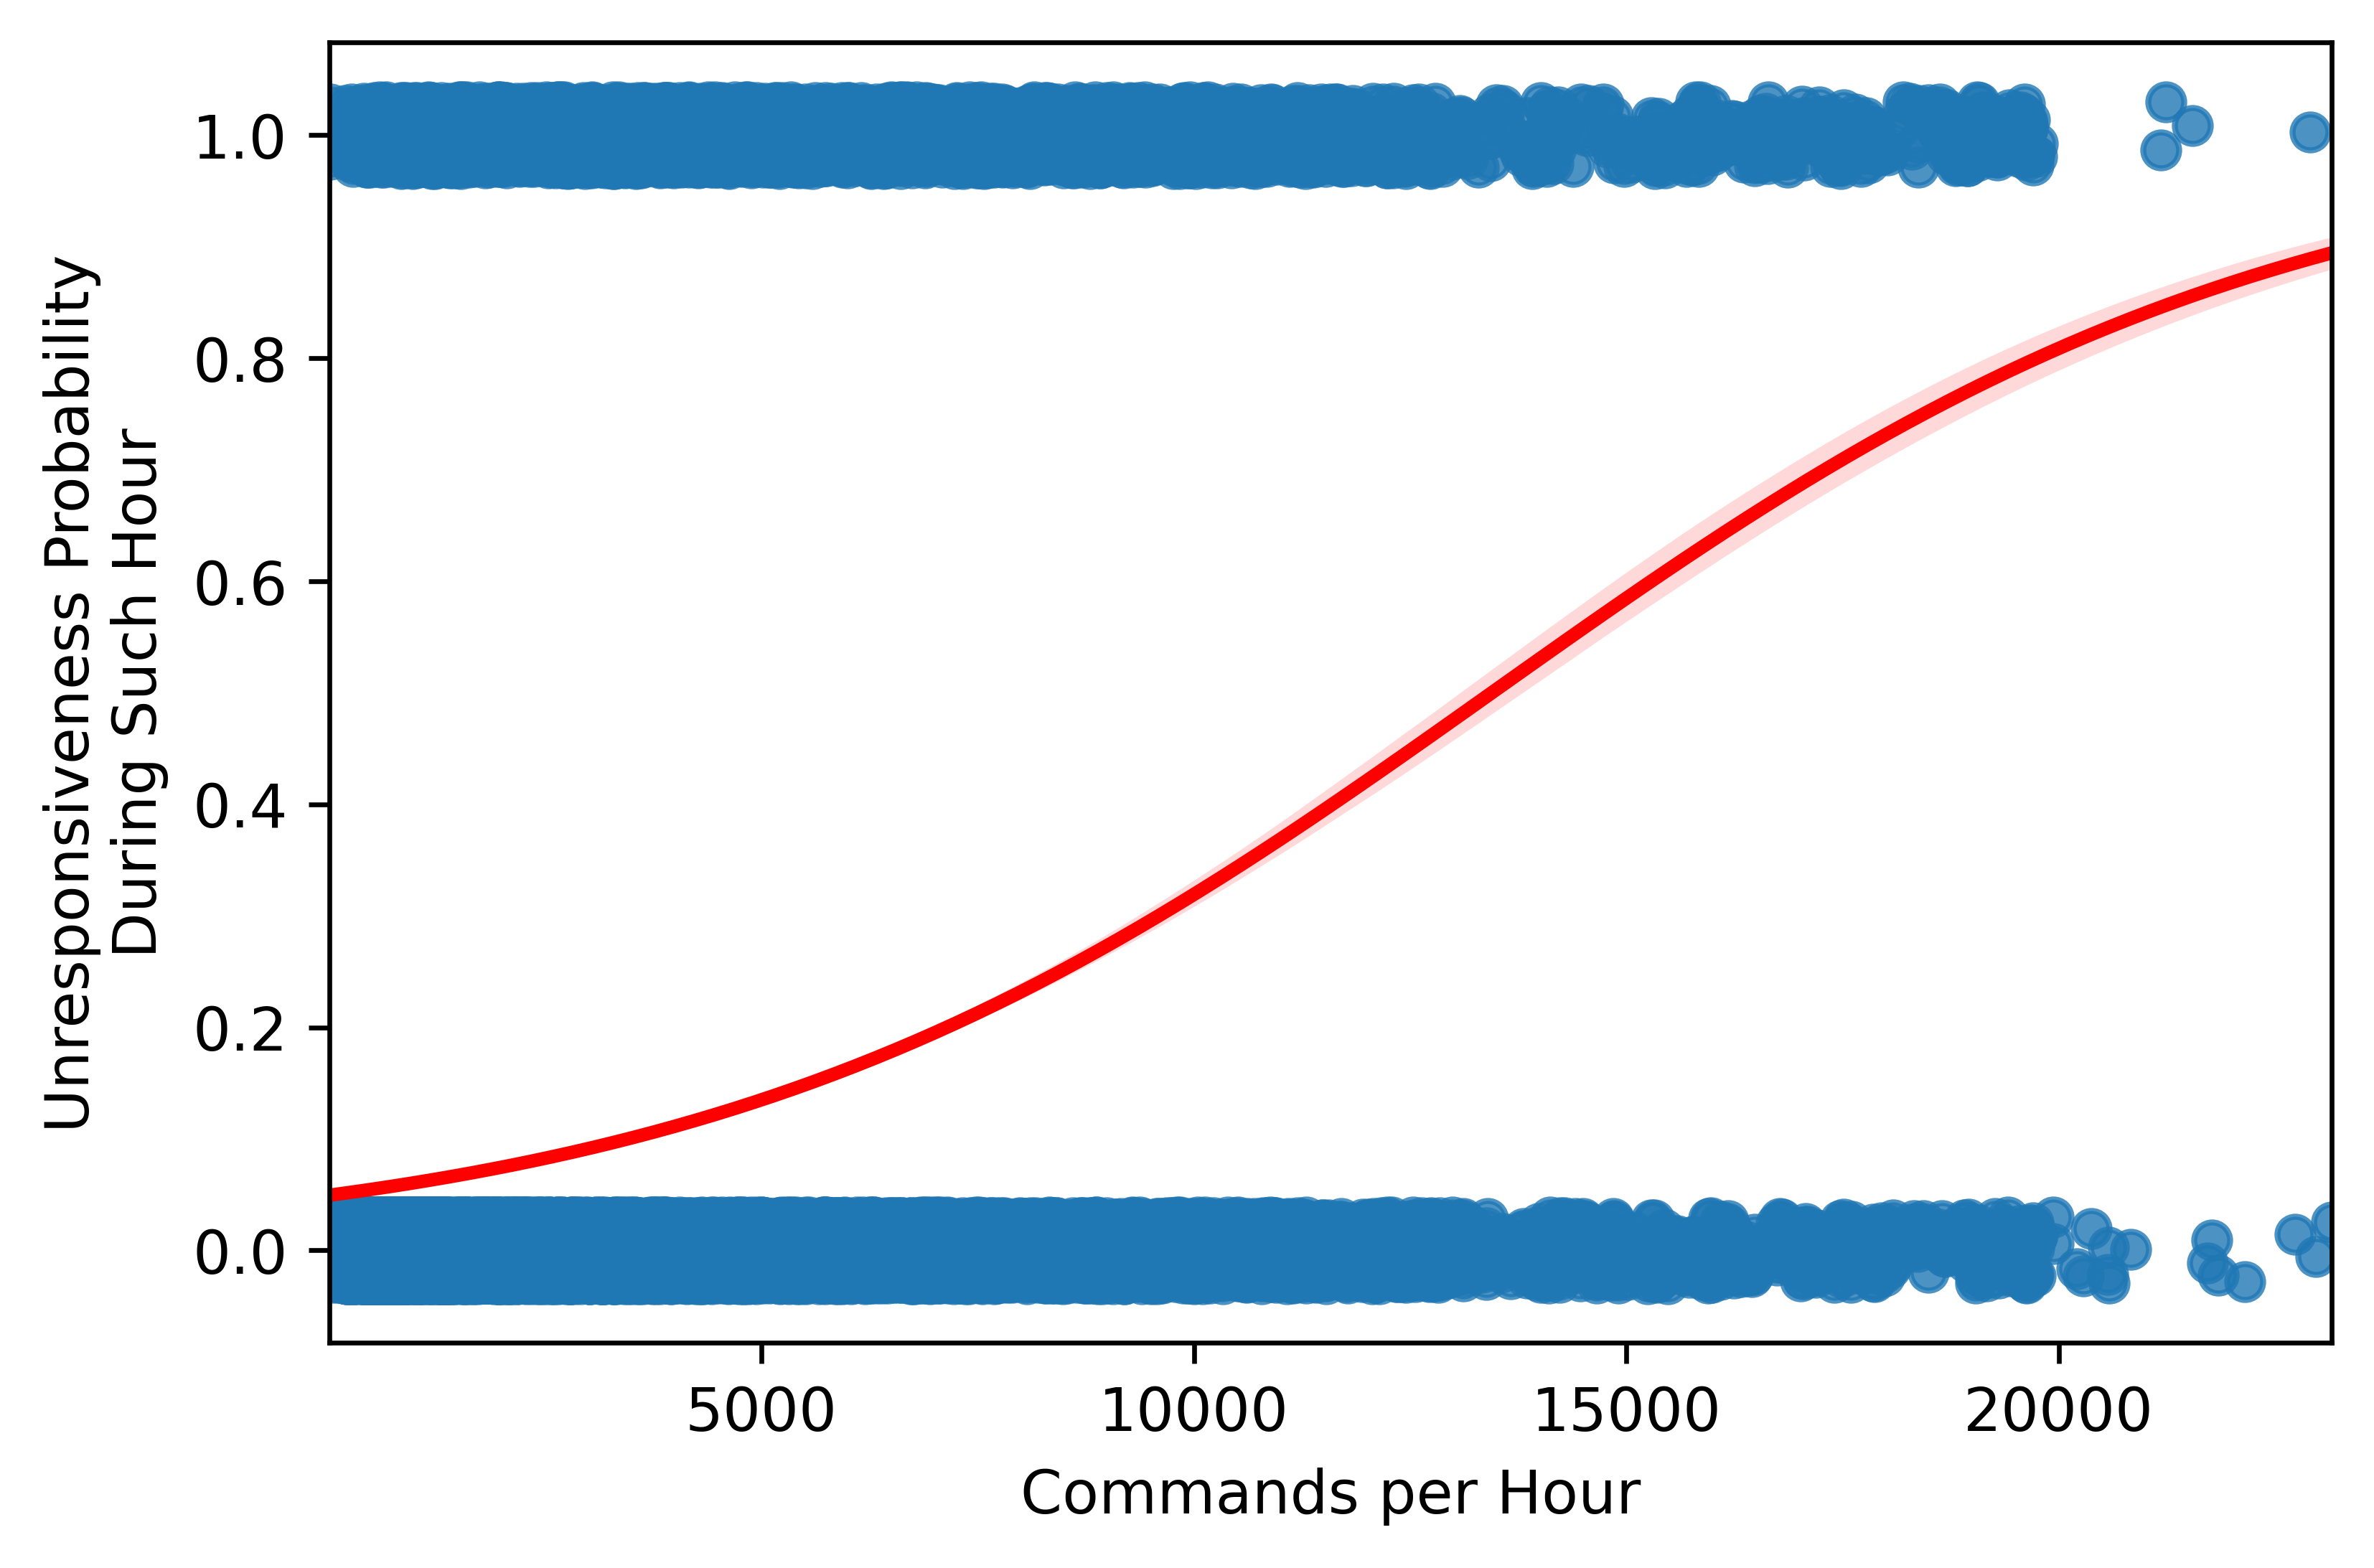

In [44]:
# Plot logistic model fit for timeouts vs. commands (1 hour rolling)
fig, ax = plt.subplots(figsize = (6, 4), facecolor = 'white', dpi = 600)

sns.regplot(x = 'COMMANDS', 
            y = 'TIMEOUT', 
            data = ce5_ce6_log.sample(50000),
            logistic = True, 
            line_kws = {"color": "red"}, 
            y_jitter = 0.03, 
            ax = ax
)

ax.set_xlabel('Commands per Hour')
ax.set_ylabel('Unresponsiveness Probability\nDuring Such Hour')

plt.show()